# Comparison `msl` high resolution

In [1]:
import os
import json 
import subprocess
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

import xbitinfo as xb
import xarray as xr

/home/datacomp/miniconda3/envs/bitinfo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

In [3]:
# load data
path_to_data = 'data/netcdf/ecmwf_hs3g_20181101_msl.nc'  # change this
ds = xr.open_dataset(path_to_data)
# ds = ds_all.isel(time=0)

In [5]:
ds = ds.sel({'longitude': ds.longitude[::],
                   'latitude': ds.latitude[:12000]
                  })

In [6]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 24000, latitude: 12000, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.015 0.03 0.045 ... 360.0 360.0 360.0
  * latitude   (latitude) float32 90.0 89.99 89.97 ... -89.96 -89.97 -89.99
  * time       (time) datetime64[ns] 2018-11-01T18:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-23 10:27:17 GMT by grib_to_netcdf-2.30.2: grib_to_n...

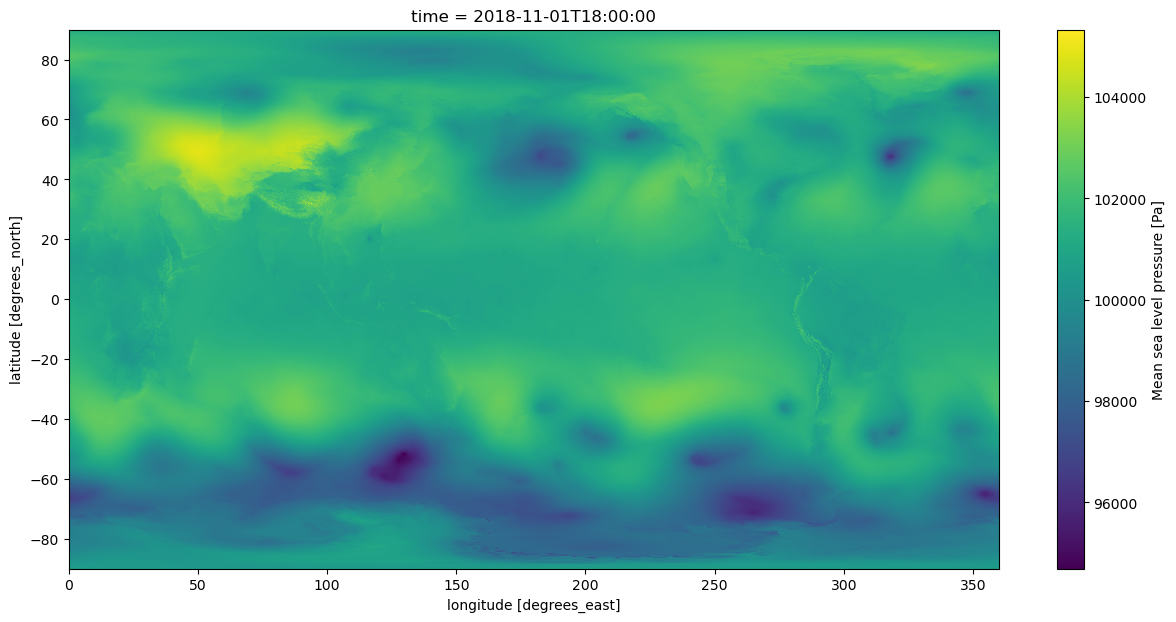

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
ds['msl'].plot(ax=ax)

<Axes: title={'center': 'Statistical distributions'}, xlabel='value', ylabel='Probability density'>

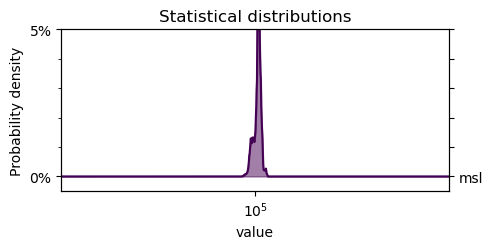

In [8]:
xb.plot_distribution(ds)

---

In [9]:
# get information content per bit
info_per_bit = xb.get_bitinformation(ds, dim="latitude",
                                     # implementation="python"
                                    )

Processing var: msl for dim: latitude: 100%|██████████████████████| 1/1 [00:37<00:00, 37.89s/it]


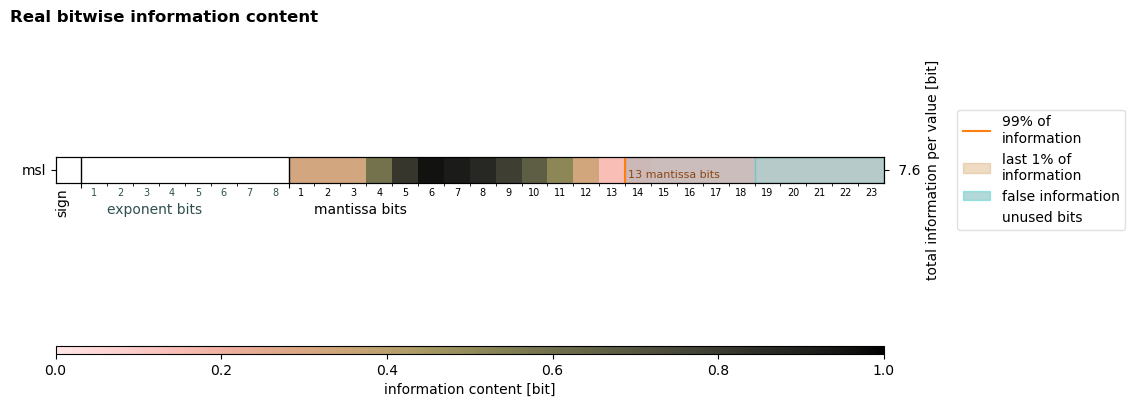

In [10]:
fig = xb.plot_bitinformation(info_per_bit)

In [11]:
# get keepbits
keepbits = xb.get_keepbits(info_per_bit, 0.99)
keepbits

<xarray.Dataset>
Dimensions:   (inflevel: 1)
Coordinates:
    dim       <U8 'latitude'
  * inflevel  (inflevel) float64 0.99
Data variables:
    msl       (inflevel) int64 13

In [12]:
# apply bitrounding 8 kb
ds_bitrounded_99p = xb.xr_bitround(ds, keepbits)

In [13]:
# apply bitrounding 10 kb
ds_bitrounded_10 = xb.xr_bitround(ds, 10)

In [14]:
# apply bitrounding 15 kb
ds_bitrounded_15 = xb.xr_bitround(ds, 15)

---

In [15]:
ds_bitrounded_15.to_compressed_netcdf("bitrounded_compressed_15.nc")

In [16]:
ds_bitrounded_10.to_compressed_netcdf("bitrounded_compressed_10.nc")

In [17]:
ds_bitrounded_99p.to_compressed_netcdf("bitrounded_compressed_99p.nc")

In [19]:
ds.to_netcdf("original.nc")

In [20]:
!du -hs *.nc

14M	bitrounded_compressed_10.nc
116M	bitrounded_compressed_15.nc
52M	bitrounded_compressed_99p.nc
1.1G	ecmwf_hs3g_20181101_msl.nc
1.1G	original.nc


In [21]:
!rm *.nc

rm: remove write-protected regular file 'ecmwf_hs3g_20181101_msl.nc'? ^C


---

In [23]:
at_least_zero = lambda x: max(x, 0)

chunk_long, chunk_lat = [2400, 1200] # for int division
vrbs = ['longitude', 'latitude']
var = 'latitude'

dss = []
dss_bitrounded = []
dss_kbits = []

long_c = int(ds.longitude.size / chunk_long)
lat_c = int(ds.latitude.size / chunk_lat)


for i in range(long_c):
    for j in range(lat_c):
        temp_ds = ds.isel(longitude=slice(i*chunk_long, (i+1)*chunk_long),
                          latitude=slice(j*chunk_lat, (j+1)*chunk_lat))
        dss.append(temp_ds)
        temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
        # fig = xb.plot_bitinformation(temp_info_pbit)
        temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
        # cope with negative keepbits
        temp_keepbits = temp_keepbits.map(at_least_zero)
        dss_kbits.append(temp_keepbits)
        temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
        dss_bitrounded.append(temp_ds_bitrounded)
        temp_ds_bitrounded.to_compressed_netcdf(f"bitrounded_compressed_{i}_{j}.nc")

Processing var: msl for dim: latitude: 100%|██████████████████████| 1/1 [00:01<00:00,  1.49s/it]


In [24]:
variables = list(ds.keys())
variables

['msl']

In [25]:
for v in variables:
    fig, ax = plt.subplots(figsize=(22, 11))
        
    ds[v].plot(ax=ax)

    for i in range(len(dss_bitrounded)):
        x = float(min(dss[i].longitude[0], dss[i].longitude[-1]))
        y = float(min(dss[i].latitude[0], dss[i].latitude[-1]))
        w = float(abs(dss[i].longitude[0] - dss[i].longitude[-1]))
        h = float(abs(dss[i].latitude[0] - dss[i].latitude[-1]))
        rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                    facecolor = "none", edgecolor = "#E5E4E2",
                                    path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                    label='xxx')
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(
            f"""
            {int(dss_kbits[i][v]):2}
            """,
            (cx, cy), color='w', weight='bold', fontsize=10, ha='right', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='k')]
        )

    fig.show()

Error in callback <function _draw_all_if_interactive at 0x7f15c8cbad40> (for post_execute):


MemoryError: Unable to allocate 8.58 GiB for an array with shape (288000000, 4) and data type float64

MemoryError: Unable to allocate 2.15 GiB for an array with shape (288000000,) and data type int64

<Figure size 2200x1100 with 2 Axes>

In [27]:
!du -shc *.nc | grep total

OSError: [Errno 12] Cannot allocate memory

55M     total

In [28]:
!rm *.nc

OSError: [Errno 12] Cannot allocate memory